In [6]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import tqdm
import datetime
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
path = './dataset/train_images/' # Path to directory which contains classes
model = "Xception"
folder_name = "{0}_{1}".format(model, datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S"))
checkpoint_folder = './checkpoints/{0}/'.format(folder_name)
tensorboard_folder = "tensorboard/fit/{0}/".format(model)

try:
    os.mkdir(tensorboard_folder, 0o755)
except:
    pass
os.mkdir(checkpoint_folder, 0o755)

log_dir = tensorboard_folder + datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_filepath = checkpoint_folder + 'epoch-{epoch:02d}-val_loss-{val_loss:.2f}.tf'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_loss', 
                                                         save_weights_only=True,
                                                         mode='min')

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                       min_delta=1e-4,
                                                       patience=15,
                                                       verbose=1,
                                                       mode="min")

classes = os.listdir(path) # List of all classes
print('Total number of categories: {0}'.format(len(classes)))

Total number of categories: 9


Total number of images in dataset: 7479


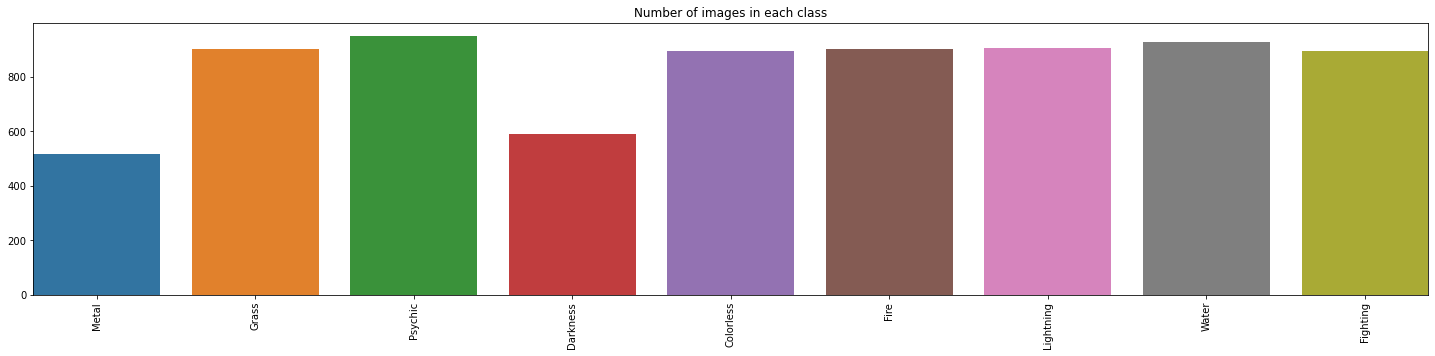

In [14]:
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))

num_images = sum(list(counts.values()))
print('Total number of images in dataset: {0}'.format(num_images))

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.barplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    dtype='float32',
    #horizontal_flip = True,
    #vertical_flip = True,
    #rotation_range = 45,
    #zoom_range = 0.2,
    #width_shift_range = 0.15,
    #height_shift_range = 0.15,
    #shear_range = 0.2
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train_images',
    batch_size=8,
    target_size=(300,300),
    class_mode='sparse',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'dataset/train_images',
    batch_size=8,
    target_size=(300,300),
    class_mode='sparse',
    subset="validation"
)

In [ ]:
train_generator.class_indices

In [ ]:
balance_weights = {}

max_count = max(counts.values())
for k, v in counts.items():
    balance_weights[train_generator.class_indices[k]] = max_count/v

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
base_model = tf.keras.applications.Xception(input_shape=(300,300,3), classes=9, weights='imagenet', include_top=False)
base_model.trainable = False
inputs = tf.keras.Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(train_generator.class_indices.keys()), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=250, verbose=True, 
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stop_callback],
                    validation_data=validation_generator, class_weight=balance_weights)

In [ ]:
best_epoch = np.argmin(history.history['val_loss']) + 1
best_loss = np.min(history.history['val_loss'])

In [ ]:
base_model.trainable = True
model.compile(optimizer = tf.keras.optimizers.Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.load_weights(checkpoint_folder+'epoch-{0:02d}-val_loss-{1:.2f}.tf'.format(best_epoch, best_loss))
history = model.fit(train_generator, epochs=250, verbose=True, 
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stop_callback],
                    validation_data=validation_generator, class_weight=balance_weights)

In [ ]:
scores = model.evaluate(x=validation_generator, verbose=1)

In [ ]:
img = np.array(cv2.imread("./dataset/test_images/6.jpg", cv2.IMREAD_COLOR))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img/256.0

plt.imshow(img)

res = model.predict(np.array([img]))[0]
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(res))], str(np.max(res)*100)+"%")

In [ ]:
Y_pred = model.predict(validation_generator, 2084 // 8+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['Colorless', 'Darkness','Fighting','Fire','Grass','Lightning','Metal','Psychic','Water']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
print('Confusion Matrix')
c_matrix = confusion_matrix(validation_generator.classes, y_pred)

fig, ax = plt.subplots()
ax.matshow(c_matrix,  cmap=plt.cm.Blues)
for i in range(9):
    for j in range(9):
        c = c_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center', fontdict={'color': 'magenta'})